# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [10]:
import numpy as np
from scipy import optimize
import sympy as sm

# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from modelproject import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

I choose to model the Green Solow model, where I wish to look at differentiating abatement costs, as is described in the course Advanced Economics of the Environment and Climate Change.

The equations are given as follows.

Consider the **Green Solow-model** where:

1. $Q$ is gross output (GDP) 
2. $R$ is resources spent on pollution abatement
3. $Y$ is Q-R, which is net output
4. $K_t$ is capital
5. $L_t$ is labor (growing with a constant rate of $n$)
6. $B$ is an index of labor efficiency
7. $g$ is the growth rate of B
8. $E$ is the total emissions of pollutants
9. $\omega$ is the emission coefficient
10. $z$ is the rate of decline in $\omega$
11. $s$ is the savings rate
12. $n$ is the growth rate of labor force
13. $\delta$ is the rate of depreciation of capital stock

**The GDP** is dependant on the production function: 

$$
Q=K_{t}^{\alpha}(B_{t}L_{t})^{1-\alpha}
$$


**The fraction of output spent on pollution abatement** is also dependant on the production function, with a constant rate $\theta$: 

$$
Y_{t}=Q_{t}(1-\theta)
$$


**The net investment in physical capital** takes into account the depreciation of both physical capital and natural capital. S is the share of net output we save and substract the amount of capital that is decreasing over time. 

$$
\dot{K}_{t}=sY_{t}-\delta K_t, \quad \quad \quad 0<s<1
$$



**The change in labor** is dependant on the labor in period t and the growth rate:

$$
\dot{L}=nL_t \Leftrightarrow L_{t}=L_{0}e^{nt},\quad \quad \quad n>0, \quad L_0>0
$$

**The index of labor efficiency** in the same manner: 

$$
\dot{B}=gB_t \Leftrightarrow B_{t}=B_{0}e^{nt},\quad \quad \quad g>0, \quad B_0>0
$$


**The emissions** depend on the emission coefficient and the output: 

$$
E_{t}=\omega_{t}Q_{t}(1-\theta)
$$



The main dynamic equation is then:

$$
\dot{k}_{t}=s(1-\theta)k_{t}^{\alpha}-(\delta +g+n)k_t
$$



## Analytical solution

I use Sympy for the purpose of finding an analytical solution to the problem:

In [11]:

# Define variables and parameters
k = sm.Symbol('k')
s = sm.Symbol('s', positive=True)
theta = sm.Symbol('theta', positive=True)
alpha = sm.Symbol('alpha', positive=True)
delta = sm.Symbol('delta', positive=True)
g = sm.Symbol('g', positive=True)
n = sm.Symbol('n', positive=True)

# Define the equation
eq = s*(1-theta)*k**alpha - (delta + g + n)*k

# Solve for k
k_star = sm.solve(eq, k)[0]

# Display the result
k_star



(delta + g + n)**(1/(alpha - 1))/(s*(1 - theta))**(1/(alpha - 1))

#### This corresponds to the solution I get by hand:

$$
k^*=(\frac{s(1-\theta)}{\delta+g+n})^{1/(1-\alpha)}
$$

Thereby the steady state of capital is increasing in savings and decreasing in depreciation rate, growth rate of labour and growth rate of labour efficiency. Furthermore it is decreasing in the fraction of output spent on pollution abatement. 

## Numerical solution

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out.

Firstly, I define the parameters I need for the model in my ss_func. I then use this to find the steady state function for baseline scenario with low abatement:

In [12]:
#Define the lambdify function:
ss_func = sm.lambdify((s, g, n, delta, alpha, theta), k_star)

In [13]:
# Evaluate function with low abatement
print(ss_func(0.2,0.0186,0.0126,0.07,0.35,0.015))

2.786473672701261


I also find this using the unit root method. The function is presented in the py file. 

In [18]:
solve_ss(0.2,0.0186,0.0126,0.07,0.35,0.015)

the steady state for k is 2.7864736727011303


### I then simulate the optimization: 


#### Note, I have not yet gotten this code to work, suggestions are welcome. I have included an attempt both here and in the py file.

Firstly I define the model:

In [19]:
class GreenSolow:
    def __init__(self, par):
        self.par = par
        
    def setup(self):
        """ baseline parameters """
        
        par = self.par
        
        # a. household
        par.sigma = 2.0 # CRRA coefficient
        par.beta = 1/1.40 # discount factor

        # b. firms
        par.alpha = 0.30 # capital weight
        par.theta = 0.05 # fraction of output spent on pollution abatement
        par.delta = 0.50 # depreciation rate

        # c. government
        par.tau_w = 0.10 # labor income tax
        par.tau_r = 0.20 # capital income tax

        # d. environmental
        par.omega = 0.02 # emission coefficient
        par.z = 0.03 # rate of decline in emission coefficient

        # e. misc
        par.K_lag_ini = 1.0 # initial capital stock
        par.B_lag_ini = 0.0 # initial index of labor efficiency
        par.simT = 50 # length of simulation

        # f. growth rates
        par.n = 0.01 # labor force growth rate
        par.g = 0.02 # growth rate of labor efficiency
        
        # g. savings rate
        par.s = 0.3 # savings rate

    def y(self, q):
        """ Output """
        alpha = self.par.alpha
        return q**alpha
    
    def q(self, k, b, l):
        """ Effective labor-augmented capital """
        omega = self.par.omega
        z = self.par.z
        return (k**alpha)*(l*np.exp(-b))**(1-alpha)*np.exp(-omega*np.exp(-z*t))
    
    def invest(self, y, k):
        """ Net investment in physical capital """
        s = self.par.s
        delta = self.par.delta
        return s*y - delta*k
    
    def update_capital(self, k, l, b, t):
        """ Update capital stock """
        y = self.y(self.q(k, b, l))
        i = self.invest(y, k)
        k_new = k + i
        l_new = l * np.exp(self.par.n)
        b_new = b + self.par.g
        return k_new, l_new, b_new
    
    def simulate(self):
        """ Simulate model """
        par = self.par
        
        # initial values
        k = par.K_lag_ini
        l = 1
        b = par.B_lag_ini
        
        # simulate the model
        k_path, l_path, b_path = [k], [l], [b]
        par.simT=50
        for t in range(par.simT):
            k, l, b = self.update_capital(k, l, b, t)
            k_path.append(k)
            l_path.append(l)
            b_path.append(b)
            
        # store results
        self.K = k_path
        self.L = l_path
        self.B = b_path

In [23]:
print(par.simT)

NameError: name 'par' is not defined

In [24]:
par = Parameters()
model = GreenSolow(par)

# simulate the model
model.simulate()

# plot the results
import matplotlib.pyplot as plt
plt.plot(model.K, label='Capital Stock')
plt.plot(model.L, label='Labor')
plt.plot(model.B, label='Efficiency')
plt.plot(model.Y, label='Output')
plt.plot(model.C, label='Consumption')
plt.plot(model.I, label='Investment')
plt.plot(model.E, label='Emissions')
plt.legend()
plt.show()

NameError: name 'Parameters' is not defined

I define the model class from the py file:

In [25]:
model = GreenSolowModelClass()

NameError: name 'GreenSolowModelClass' is not defined

I then simulate the model using the simulation definition in the py file:

In [26]:
model.simulate()

NameError: name 'model' is not defined

I then plot the solution. To include the steady state I define that function as well:

In [27]:
K_ss=((par.s(1-par.theta)/(par.delta+par.g+par.n))^(1/(1-par.alpha))

SyntaxError: unexpected EOF while parsing (1107370522.py, line 1)

I then wish to create a graph like the one presented in lecture 4-OLG:

NameError: name 'model' is not defined

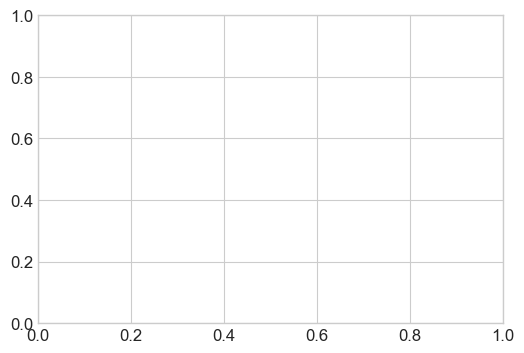

In [28]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
#ax.axhline(K_ss,ls='--',color='black',label='analytical steady state')
ax.legend(frameon=True)
fig.tight_layout()
K_lag_old = model.sim.K_lag.copy()

# Further analysis

I wish to look at different values for income spent on abatement.

#### Therefore the steady state GDP per capita is higher for the low abatement costs 

In [39]:
# Define parameters
s = 0.2
g = 0.0186
n = 0.0126
alpha = 0.35
delta = 0.07

# Define function for steady-state value of k
def k_star(theta):
    f = lambda k: k**alpha
    obj_k_star = lambda k_star: (s*(1-theta)*f(k_star) -(delta+g+n)*k_star)
    result = optimize.root_scalar(obj_k_star,bracket=[0.1,100],method='brentq')
    return result.root

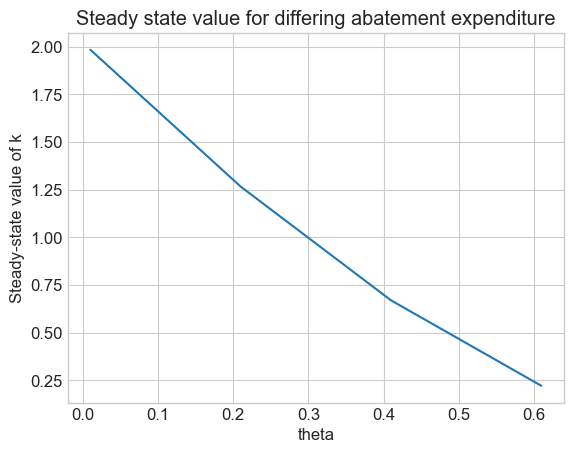

In [40]:
# Create array of values for theta
theta_vals = np.arange(0.01, 0.81, 0.2)

# Compute steady-state value of k for each value of theta
k_star_vals = [k_star(theta) for theta in theta_vals]

# Plot results
import matplotlib.pyplot as plt
plt.plot(theta_vals, k_star_vals)
plt.xlabel('theta')
plt.ylabel('Steady-state value of k')
plt.title('Steady state value for differing abatement expenditure')
plt.show()

#### Therefore the steady state GDP per capita is higher for the low abatement costs. 

Furthermore, I wish to look at what happens if I insert a tax on emissions. Thereby the Y function is augmented to: 

$$
Y_{t}=Q_{t}(1-\theta)+\tau E_t
$$



In [42]:
# Define parameters
s = 0.2
g = 0.0186
n = 0.0126
alpha = 0.35
delta = 0.07
theta = 0.15

# Define function for steady-state value of k
def k_star_tau(tau):
    f = lambda k: k**alpha
    obj_k_star = lambda k_star: (s*(1-theta-tau)*f(k_star) -(delta+g+n)*k_star)
    result = optimize.root_scalar(obj_k_star,bracket=[0.1,100],method='brentq')
    return result.root

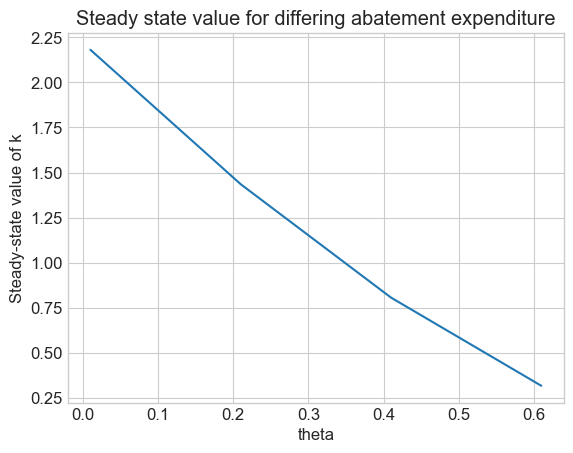

In [43]:
# Create array of values for theta
tau_vals = np.arange(0.01, 0.81, 0.2)

# Compute steady-state value of k for each value of theta
k_star_vals = [k_star_tau(tau) for tau in tau_vals]

# Plot results
import matplotlib.pyplot as plt
plt.plot(theta_vals, k_star_vals)
plt.xlabel('tau')
plt.ylabel('Steady-state value of k')
plt.title('Steady state value for differing abatement expenditure')
plt.show()

### Conclusion 
#### Therefore we see that, as expected, the increase in taxes will act in the same manner as the increase in abatement expenditue as expected.

### This modification needs the original simulation to work.

# Conclusion

Add concise conclusion. 